<a href="https://colab.research.google.com/github/mlcoder0/Stock-Market-Predictions/blob/main/NLP_StockMarket2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Exercise. Sentence Sentiment? { display-mode: "form" }

#@markdown What sentiment would you assign Sentence A?
A  = "neutral" #@param ["positive", "negative", "neutral", ""]

#@markdown What sentiment would you assign Sentence B?
B = 'positive' #@param ["positive", "negative", "neutral", ""]


if A == "negative":
  print("Yes, since the company did not profit you can interpret this as being negative! You could also interpret it as neutral.")
elif A == "neutral":
  print("Yes, since the company did not profit you can interpret this as being neutral! You could also interpret it as negative.")
else:
  print('Not quite the right sentiment!')
if B == "positive":
  print("Yes, since the company made significant profits you can interpret that as being positive!")
else:
  print('Not quite the right sentiment!')


Yes, since the company did not profit you can interpret this as being neutral! You could also interpret it as negative.
Yes, since the company made significant profits you can interpret that as being positive!


# **LSTM**

In [ ]:
#@title Run this to load the datasets and setup the environment. { display-mode: "form" }
# Run this every time you open the spreadsheet
import sys
import os

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with HiddenPrints():
  %load_ext autoreload
  %autoreload 2
  from collections import Counter
  from importlib.machinery import SourceFileLoader
  import numpy as np
  from os.path import join
  import warnings
  warnings.filterwarnings("ignore")
  from torchtext.vocab import GloVe
  import nltk
  nltk.download('punkt', quiet=True)
  import seaborn as sns
  import matplotlib

  from nltk.tokenize import sent_tokenize, word_tokenize
  from nltk.stem.wordnet import WordNetLemmatizer
  from nltk.stem.porter import *
  from nltk.corpus import stopwords
  nltk.download('stopwords', quiet=True)
  from sklearn.feature_extraction.text import CountVectorizer
  from sklearn.linear_model import LogisticRegression
  from sklearn.model_selection import train_test_split
  import pandas as pd
  from sklearn.metrics import multilabel_confusion_matrix
  from sklearn import metrics
  import gdown
  import string
  import numpy
  import matplotlib.pyplot as plt

  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  !pip install Keras-Preprocessing
  from keras.preprocessing.text import Tokenizer
  from keras_preprocessing.sequence import pad_sequences
  from keras.models import Sequential
  from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  from keras.layers import Dropout
  import re
  from nltk.corpus import stopwords
  from nltk import word_tokenize
  STOPWORDS = set(stopwords.words('english'))
  from bs4 import BeautifulSoup

  from keras.preprocessing.text import Tokenizer
  import string

  from sklearn.metrics import confusion_matrix

  !wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
  !wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(7,6))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()


def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

PUNCTUATION = '!#$%&()*,-./:;<=>?@^_`{|}~'

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    # text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

def pad_sequences_train(df_train, df_test):
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS+1, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(df_train['Sentence'].values)
  word_index = tokenizer.word_index
  X = tokenizer.texts_to_sequences(df_train['Sentence'].values)
  X_train = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  return X_train

def pad_sequences_test(df_train, df_test):
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS+1, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(df_train['Sentence'].values)
  word_index = tokenizer.word_index
  X = tokenizer.texts_to_sequences(df_test['Sentence'].values)
  X_test = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  return X_test

df_train2 = get_finance_train()
df_test2 = get_finance_test()
df_train2['Sentence'] = df_train2['Sentence'].apply(clean_text)
df_test2['Sentence'] = df_test2['Sentence'].apply(clean_text)
def run_model(X_train, y_train, X_test, y_test, epochs=5, batch_size=64, max_sequence_length=256, max_nb_words=1000, embedding_dim=300):
  if any(x is None for x in [X_train, y_train, X_test, y_test, epochs, max_sequence_length, max_nb_words, embedding_dim]):
    print('Replace the None values above with your new values before calling the run_model() function.')
    return None, None, None
  def pad_seq_train(df_train, df_test, max_seq):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS+1, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df_train['Sentence'].values)
    word_index = tokenizer.word_index
    X = tokenizer.texts_to_sequences(df_train['Sentence'].values)
    X_train = pad_sequences(X, maxlen=max_seq)
    return X_train
  def pad_seq_test(df_train, df_test, max_seq):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS+1, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df_train['Sentence'].values)
    word_index = tokenizer.word_index
    X = tokenizer.texts_to_sequences(df_test['Sentence'].values)
    X_test = pad_sequences(X, maxlen=max_seq)
    return X_test
  X_train2 = pad_seq_train(df_train2, df_test2, max_sequence_length)
  X_test2 = pad_seq_test(df_train2, df_test2, max_sequence_length)
  model = Sequential()
  model.add(Embedding(max_nb_words+1, embedding_dim, mask_zero=True, input_length=max_sequence_length))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(n_labels, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  history = model.fit(X_train2,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
  test_loss, test_accuracy = model.evaluate(X_test, y_test)
  return model, history, test_accuracy


EMBEDDING_DIM = 300

plt.rcParams.update({'font.size': 22})

nltk.download('wordnet', quiet=True)

print ("Train & Test Files are loaded")

Train & Test Files are loaded


In [ ]:
df_train = get_finance_train()
df_test = get_finance_test()

In [ ]:
print(len(df_train))
df_train.head()

2037


,Sentence,Label
0,Autotank Group is part of Aspo 's Systems Divi...,1
1,"The contract includes design , construction , ...",1
2,Rapala said it estimates it will make savings ...,2
3,The share capital of Alma Media Corporation (b...,1
4,The financial impact is estimated to be some 1...,2


In [ ]:
print(len(df_test))
df_test.head()

227


,Sentence,Label
0,"In the third quarter of 2010 , net sales incre...",2
1,Foundries division reports its sales increased...,2
2,Financing of the project will come mainly from...,1
3,"Sukhraj Dulai , of the 2900 block of Boni Sue ...",1
4,Finland 's leading metals group Outokumpu said...,2


In [ ]:
### YOUR CODE HERE
longest = 1
for sentence in df_train['Sentence']:
  if len(sentence) > longest:
    longest = len(sentence)
print(longest)
### END CODE

315


In [ ]:
#@title Run this cell to clean all the sentences in Finance Train and Finance Test.
#@markdown This will essentially remove our stopwords and punctuation marks.

df_train['Sentence'] = df_train['Sentence'].apply(clean_text)
df_test['Sentence'] = df_test['Sentence'].apply(clean_text)

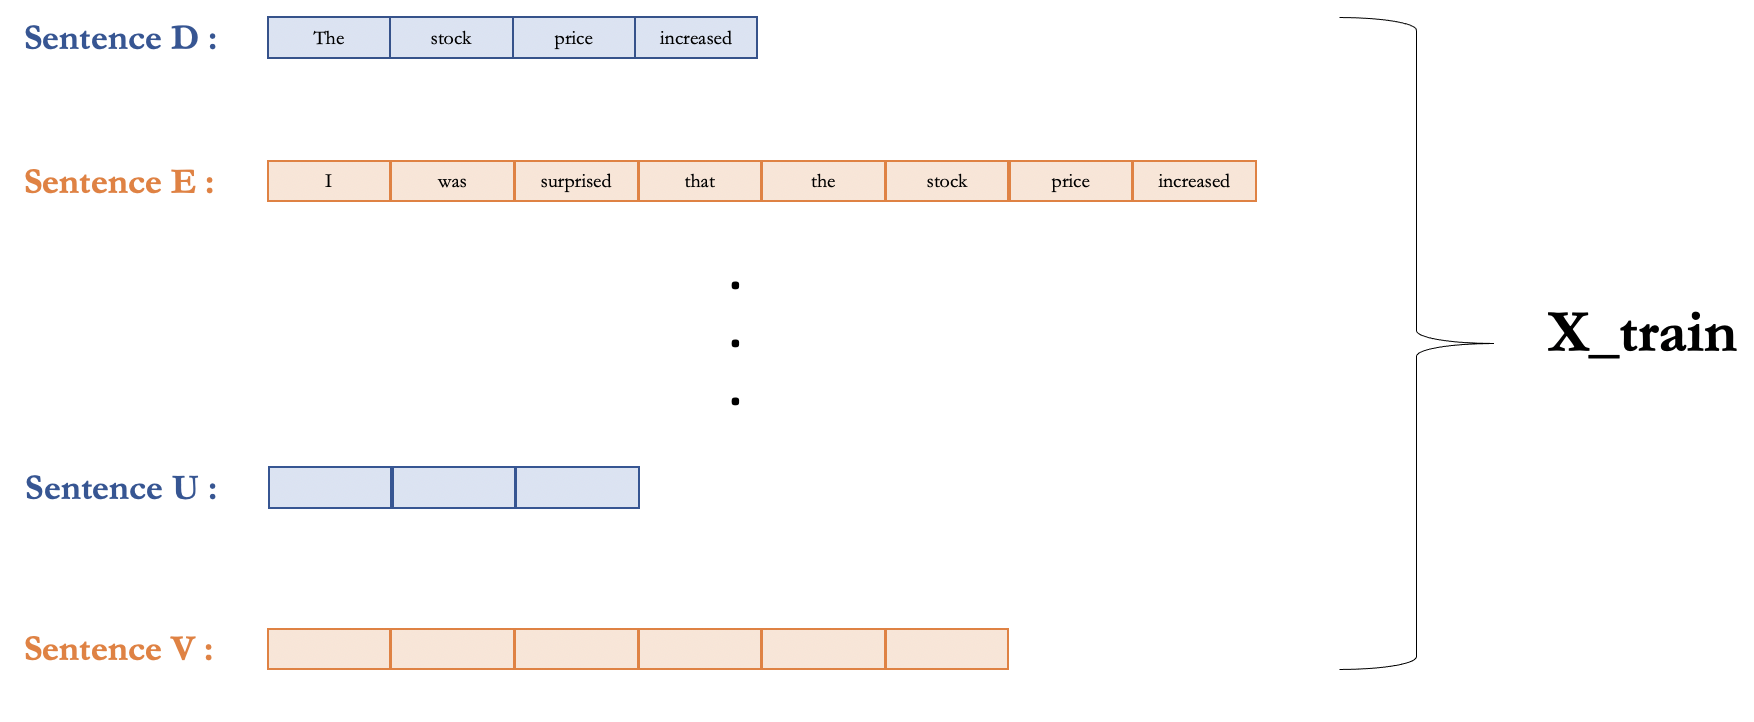

In [ ]:
MAX_SEQUENCE_LENGTH = 256

In [ ]:
MAX_NB_WORDS = 1000

#### **Training Dataset**

Call the `pad_sequences_train(df_train, df_test)` method while passing in `df_train` and `df_test` as shown and save the result in a variable named `X_train`. Thereafter, print the shape of the `numpy` array and then print the first element using `X_train[0]`. Comment on what you see!

In [ ]:
### YOUR CODE HERE
X_train = pad_sequences_train(df_train, df_test)
print(X_train.shape)
print(X_train[0])
### END CODE

(2037, 256)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   



```
# This is formatted as code
```

#### **Padding Sequences; Testing Datset**

Call the `pad_sequences_test(df_train, df_test)` method while passing in `df_train` and `df_test` as shown and save the result in a variable named `X_test`. Thereafter, print the shape of the `numpy` array.

In [ ]:
### YOUR CODE HERE
X_test = pad_sequences_test(df_train, df_test)
print(X_test.shape)
print(X_test[0])
### END CODE

(227, 256)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  72

In [ ]:
### YOUR CODE HERE
y_train = pd.get_dummies(df_train['Label']).values
print(y_train.shape)
### END CODE

(2037, 3)


#### **Creating y Dummy Variables - Testing Dataset**

Perform the same operation from above, but this time on the `df_test` dataframe. Save it in a variable named `y_test` and print out its shape.

In [ ]:
### YOUR CODE HERE
y_test = pd.get_dummies(df_test['Label']).values
print(y_test.shape)
### END CODE

(227, 3)


### **Setup and Run Your Model**

We finally have all the data pieces in place to create our model! The last parameter we have in the freedom to optimize in our network is the dimension of each of the word's representations. As we saw above, as we moved through the sequence with the LSTM, we updated the entire sequence's representation based on the individual words.

We will keep track of the number of labels and a map from the label integer to the meanings in variables `n_labels` and `label_map` below.

In [ ]:
n_labels = 3
label_map = {0 : "negative",
             1 : "neutral",
             2 : "positive"}

In [ ]:
#@title model instantiation

model = Sequential()
model.add(Embedding(MAX_NB_WORDS+1, EMBEDDING_DIM, mask_zero=True, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 300)          300300    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 256, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 461003 (1.76 MB)
Trainable params: 461003 (1.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
epochs = 5 ### YOUR CODE HERE
batch_size = 64 ### YOUR CODE HERE

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
29/29 [==============================] - 57s 2s/step - loss: 0.9232 - accuracy: 0.6661 - val_loss: 0.6722 - val_accuracy: 0.7500
Epoch 2/5
29/29 [==============================] - 57s 2s/step - loss: 0.5738 - accuracy: 0.7752 - val_loss: 0.5753 - val_accuracy: 0.7941
Epoch 3/5
29/29 [==============================] - 61s 2s/step - loss: 0.4040 - accuracy: 0.8342 - val_loss: 0.5240 - val_accuracy: 0.8333
Epoch 4/5
29/29 [==============================] - 80s 3s/step - loss: 0.2672 - accuracy: 0.9073 - val_loss: 0.5909 - val_accuracy: 0.8382
Epoch 5/5
29/29 [==============================] - 50s 2s/step - loss: 0.1761 - accuracy: 0.9400 - val_loss: 0.5181 - val_accuracy: 0.8186


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)
print(test_loss)
 ### YOUR CODE HERE
#### **Coding Exercise: Evaluate your model!**


8/8 [==============================] - 1s 119ms/step - loss: 0.4942 - accuracy: 0.8678
0.8678414225578308
0.49419984221458435


In [ ]:
training_loss = history.history["loss"]  ### YOUR CODE HERE

In [ ]:
validation_loss = history.history["val_loss"]  ### YOUR CODE HERE

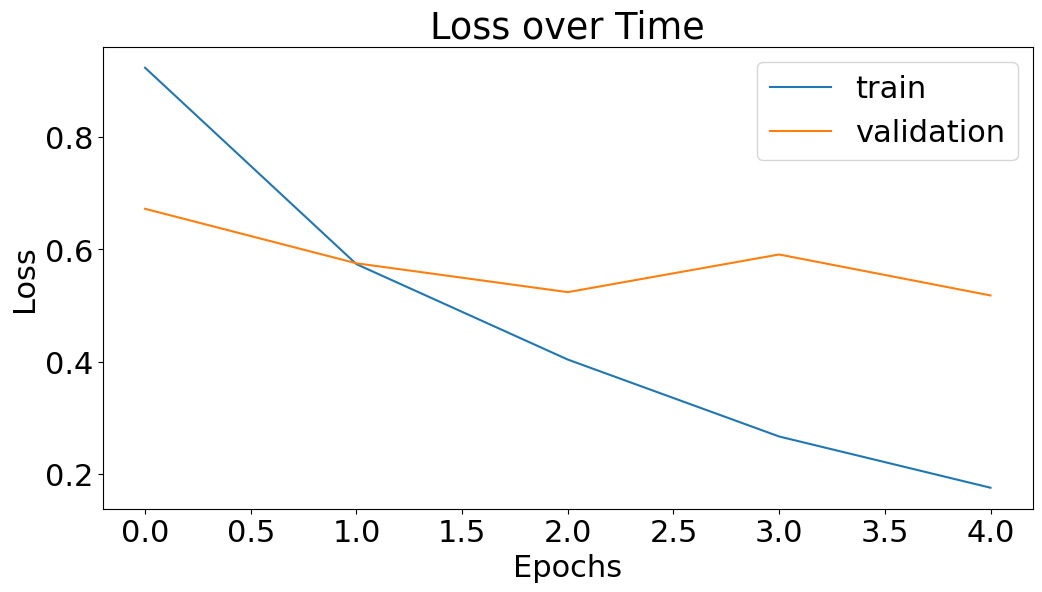

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(training_loss, label="train")
plt.plot(validation_loss, label="validation")

plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### YOUR CODE HERE

### END CODE

plt.legend()
plt.show()

#### **Plot your accuracies!**

Now, we will begin to plot the training and validation accuracies. To access the training accuracy, call `history.history["accuracy"]` and save it in a variable named `training_accuracy`. Similarly, access the validation accuracy with the call to `history.history["val_accuracy"]` and save it in a variable named `validation_accuracy`.



In [ ]:
training_accuracy = history.history["accuracy"]  ### YOUR CODE HERE
validation_accuracy = history.history["val_accuracy"]  ### YOUR CODE HERE

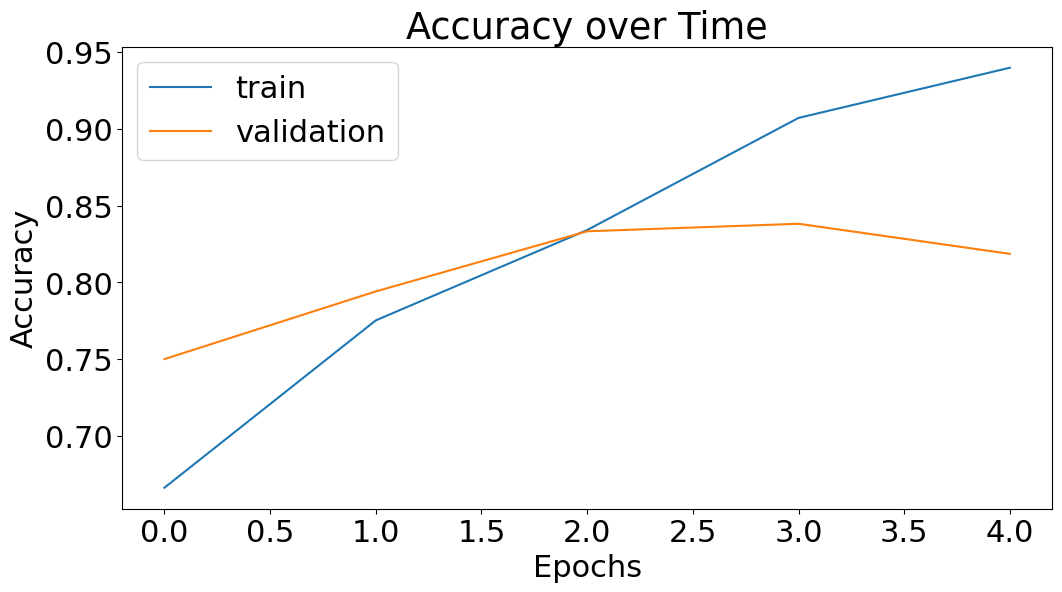

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.title('Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### YOUR CODE HERE
plt.plot(training_accuracy, label="train")
plt.plot(validation_accuracy, label="validation")
### END CODE

plt.legend()
plt.show()

# **Milestone 3: Carrying out hyperparameter optimization to improve  model.**



In [ ]:
model, history, test_acc = run_model(
    X_train=pad_sequences_train(df_train, df_test), ### YOUR CODE HERE
    y_train=pd.get_dummies(df_train['Label']).values, ### YOUR CODE HERE
    X_test=pad_sequences_test(df_train, df_test), ### YOUR CODE HERE
    y_test=pd.get_dummies(df_test['Label']).values, ### YOUR CODE HERE
    epochs=10, ### YOUR CODE HERE
    batch_size=128, ### YOUR CODE HERE
    max_sequence_length=315, ### YOUR CODE HERE
    max_nb_words=1000, ### YOUR CODE HERE
    embedding_dim=315 ### YOUR CODE HERE
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 315, 315)          315315    
                                                                 
 spatial_dropout1d_4 (Spati  (None, 315, 315)          0         
 alDropout1D)                                                    
                                                                 
 lstm_4 (LSTM)               (None, 100)               166400    
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 482018 (1.84 MB)
Trainable params: 482018 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
15/15 [==============================] - 72s 4s/step - loss: 1.0250 

#### **Plot :DD**

Using the `history` parameter returned from the `run_model()` function, plot your new training and validation loss/accuracy curves and explore the difference between these and the curves of your original model. What do you notice? What tradeoff did modifying the hyperparameters allow for?



In [ ]:
### YOUR CODE HERE
# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']
# training_accuracy = history.history['accuracy']
# validation_accuracy = history.history['val_accuracy']
# print(training_loss)
# print(validation_loss)
# print(training_accuracy)
# print(validation_accuracy)
### END CODE
test_loss, test_accuracy = model.evaluate(X_test, y_test)


8/8 [==============================] - 2s 241ms/step - loss: 0.6064 - accuracy: 0.8458


In [ ]:
# Predict on our test set
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis = - 1)
y_true = y_test.argmax(axis = - 1)

# plot the confusion matrix!
plot_confusion_matrix(y_true, y_pred)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 315), found shape=(None, 256)
